# Clase 4 - Segmentacion tiramisu
![picture](https://drive.google.com/uc?id=1Ar6KpqlsLxcLlnOrXPx6QZejStP6bV9P)

## Pre requisitos

Se actualiza fastai descargando y ejecutando el script *colab*

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Dar permiso para acceder a mi Drive

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Nos aseguramos que cualquier cambio en una librería es recargado automáticamente y que que cualquier gráfica o imagen se muestre aquí

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Importamos las librerías necesarias

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## Curso 4 - Segmentacion tiramisu

Hay un data set de imágenes basadas en Camvid, pero con imágenes más pequeñas y menos etiquetas

### Descarga del dataset

In [5]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 10.33 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [6]:
path = Path('/content/SegNet-Tutorial/CamVid')
path.ls()

[PosixPath('/content/SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/test'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/train'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val'),
 PosixPath('/content/SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/testannot')]

### Se crea el dataset

Obtenemos los nombres de las imágenes

In [7]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08117.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08027.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_07959.png')]

Los nombres de las etiquetas

In [8]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08117.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08027.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_07959.png')]

Parece que tienen el mismo nombre. 

Por lo que creamos una función para obtener el nombre de la imagen segmentada a partir del nombre de la imagen sin segmentar

In [0]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

Vemos una imagen sin segmentar

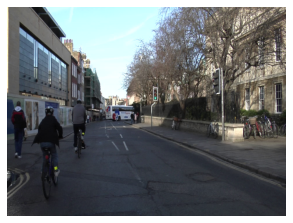

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

Vemos la misma imagen segmentada

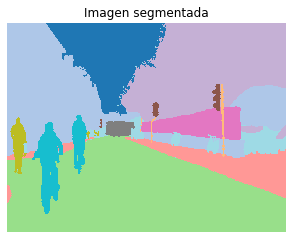

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1, title='Imagen segmentada')

Vemos como son las matrices de las imágenes segmentadas y sin segmentar

In [12]:
img_size = np.array(img.shape[1:])
src_size = np.array(mask.shape[1:])

print(img_size)
print(src_size)

[360 480]
[360 480]


Obtenemos los códigos de los números

In [0]:
codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

In [0]:
size = src_size//2

bs = 8
#bs = 4

Creamos el dataset

In [0]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

Al hacer las transformaciones indicamos que se hagan las mismas en la imagen segmentada

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

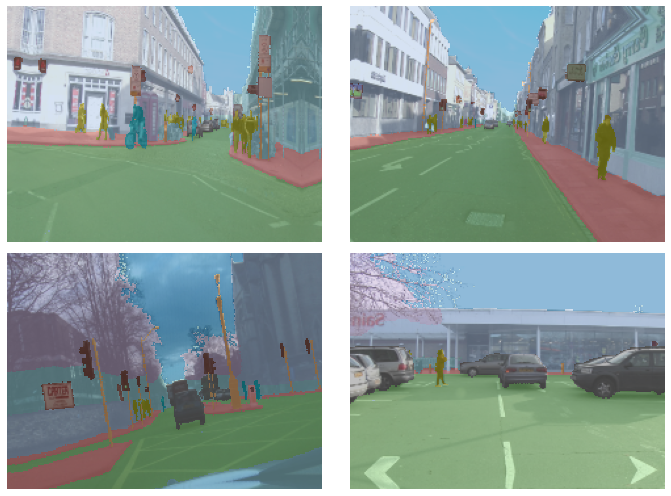

In [17]:
data.show_batch(2, figsize=(10,7))

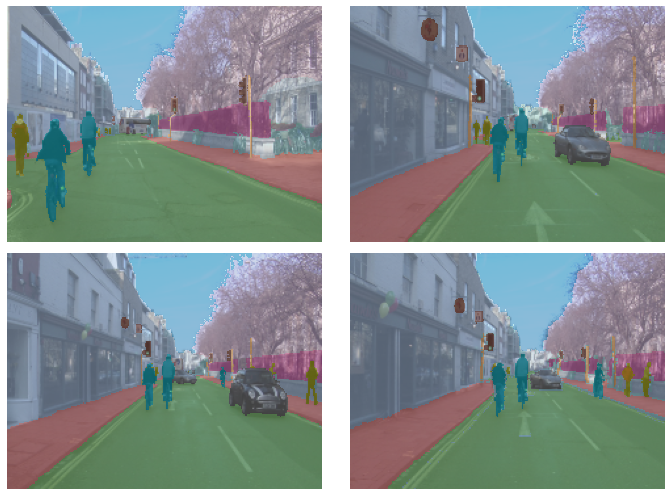

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### Se crea el modelo

Se crea un diccionario con los códigos

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

name2id

{'Building': 1,
 'Car': 8,
 'Cyclist': 10,
 'Fence': 7,
 'Pedestrian': 9,
 'Pole': 2,
 'Road': 3,
 'Sidewalk': 4,
 'Sign': 6,
 'Sky': 0,
 'Tree': 5,
 'Void': 11}

Se crea la función con la que se harán las métricas

In [0]:
def acc_camvid(input, target):
    target = target.squeeze(1)  # The output array is input array, but with all or a subset of the dimensions of length 1 removed
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
# weight decay
wd=1e-2

Se define el modelo

![unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


### Entrenamiento

#### Imagenes reducidas

In [24]:
print(src_size)
print(size)

[360 480]
[180 240]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


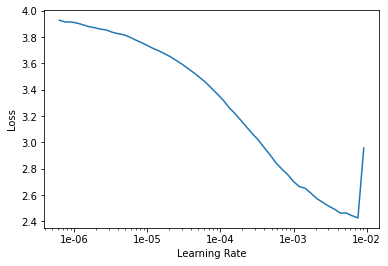

In [25]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=2e-3

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.293100,0.855238,0.768572,00:15
1,0.905206,0.637806,0.846026,00:14
2,0.714559,0.511970,0.857805,00:14
3,0.601075,0.511047,0.844138,00:14
4,0.563511,0.632020,0.829011,00:14
5,0.525617,0.461297,0.869386,00:14
6,0.581473,0.444830,0.874366,00:14
7,0.504582,0.426886,0.876074,00:14
8,0.446842,0.371330,0.889781,00:14
9,0.389526,0.334906,0.896396,00:14


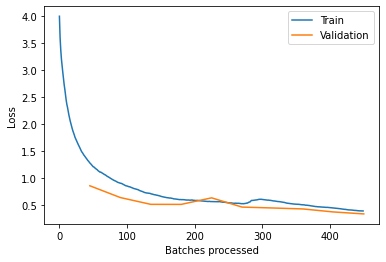

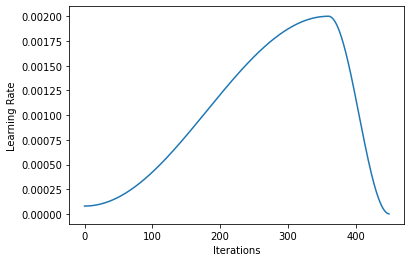

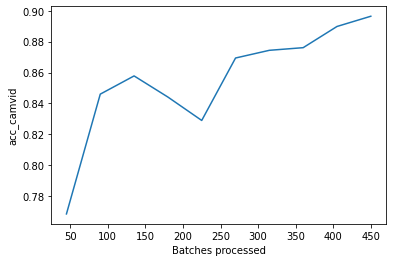

In [28]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()
learn.recorder.plot_metrics()

In [0]:
learn.save('stage-1_tiramisu')

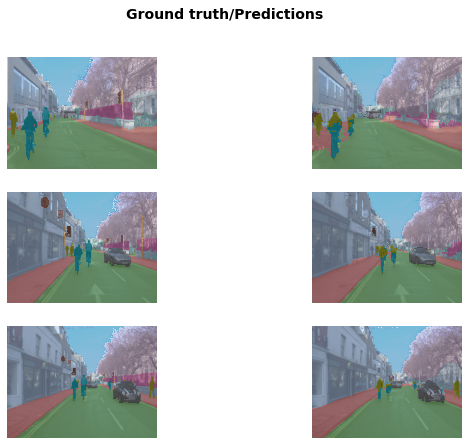

In [30]:
learn.show_results(rows=3, figsize=(10,7))

In [31]:
learn.unfreeze()
lrs = slice(lr/100,lr)
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.329840,0.317140,0.902568,00:16
1,0.328461,0.319387,0.900344,00:16
2,0.323267,0.323393,0.897280,00:16
3,0.323712,0.325590,0.900174,00:16
4,0.332688,0.322892,0.905267,00:16
5,0.343864,0.335715,0.899604,00:16
6,0.338488,0.350305,0.893975,00:16
7,0.339157,0.361488,0.887045,00:15
8,0.327588,0.390010,0.898533,00:16
9,0.317989,0.293202,0.915768,00:16


In [32]:
print(lr/100)
print(lr)

2e-05
0.002


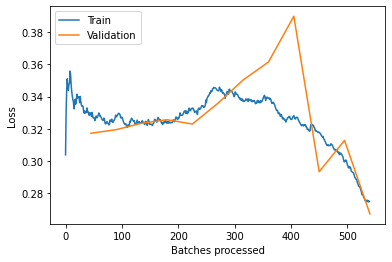

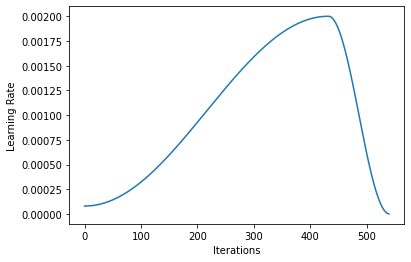

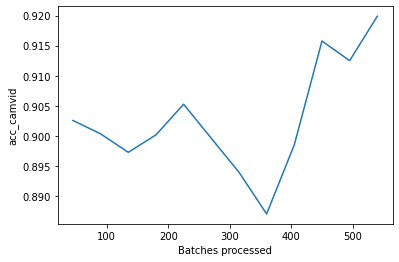

In [33]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()
learn.recorder.plot_metrics()

In [0]:
learn.save('stage-2_tiramisu');

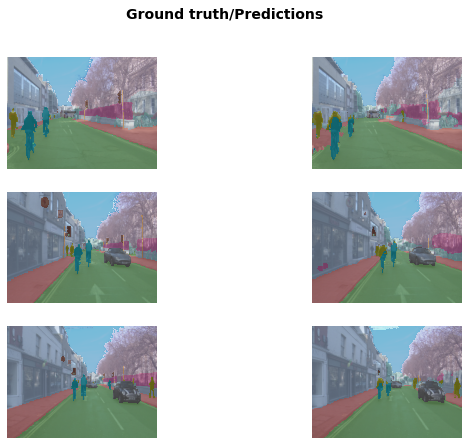

In [35]:
learn.show_results(rows=3, figsize=(10,7))

In [0]:
drive_folder = '/content/drive/My\ Drive/Colab\ Notebooks/Curso\ fastai/04\ Segmentacion'

In [0]:
!cp /content/SegNet-Tutorial/CamVid/models/stage-2_tiramisu.pth {drive_folder}

#### Imagenes a tamaño real

##### Reinicio del kernel

Para evitar problemas de 'out of memory' es necesario reiniciar el kernel y volver a ejecutar algunas celdas para volver a tener algunas variables

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 45.51 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [0]:
path = Path('/content/SegNet-Tutorial/CamVid')

In [0]:
drive_folder = '/content/drive/My\ Drive/Colab\ Notebooks/Curso\ fastai/04\ Segmentacion'

In [0]:
!mkdir /content/SegNet-Tutorial/CamVid/models

In [0]:
!cp {drive_folder}/stage-2_tiramisu.pth /content/SegNet-Tutorial/CamVid/models

In [9]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08117.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08027.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_07959.png')]

In [10]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08117.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08027.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_07959.png')]

In [0]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

In [0]:
img_f = fnames[0]
mask = open_mask(get_y_fn(img_f))

In [0]:
src_size = np.array(mask.shape[1:])

In [0]:
codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

In [0]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2

##### Entrenamiento

In [0]:
size = src_size
bs=16

In [21]:
print(src_size)
print(size)

[360 480]
[360 480]


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

In [0]:
learn.load('stage-2_tiramisu');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


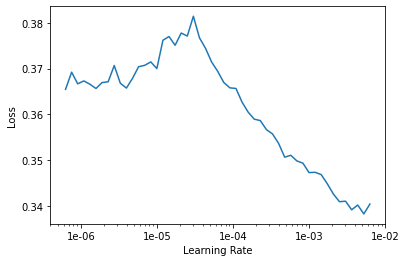

In [25]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.346201,0.365056,0.891145,00:23
1,0.326460,0.357529,0.892418,00:22
2,0.307725,0.326118,0.905903,00:22
3,0.291164,0.321131,0.905701,00:22
4,0.277753,0.278426,0.920805,00:22
5,0.264090,0.291977,0.910295,00:22
6,0.255269,0.288560,0.911815,00:22
7,0.247137,0.273478,0.920898,00:22
8,0.235372,0.276121,0.923997,00:22
9,0.221133,0.255942,0.929207,00:22


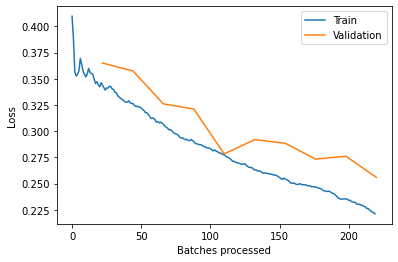

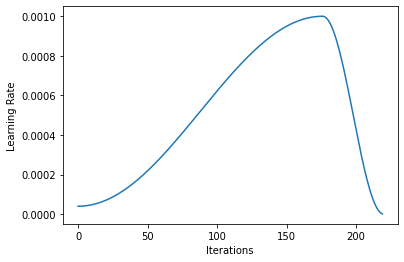

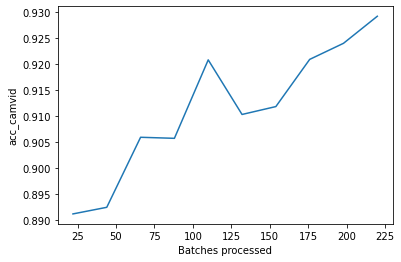

In [28]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()
learn.recorder.plot_metrics()

In [0]:
learn.save('stage-1-big_tiramisu')

In [30]:
learn.load('stage-1-big_tiramisu')

Learner(data=ImageDataBunch;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /content/SegNet-Tutorial/CamVid;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /content/SegNet-Tutorial/CamVid;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2)

In [0]:
lrs = slice(lr/1000,lr/10)

In [32]:
learn.unfreeze()
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.195802,0.255485,0.929080,00:23
1,0.193342,0.253018,0.930259,00:23
2,0.193093,0.249886,0.932382,00:23
3,0.189684,0.247180,0.933571,00:23
4,0.187233,0.246954,0.934506,00:23
5,0.185628,0.256246,0.930605,00:23
6,0.184844,0.249156,0.932894,00:23
7,0.183392,0.250654,0.932793,00:23
8,0.181446,0.247377,0.934129,00:23
9,0.179340,0.246766,0.933932,00:23


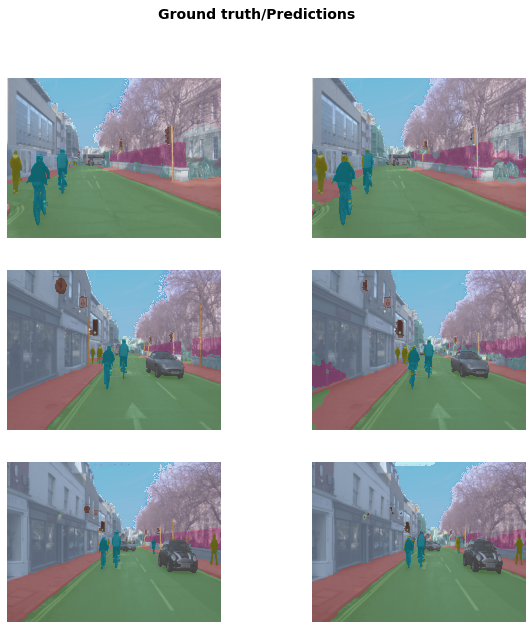

In [33]:
learn.show_results(rows=3, figsize=(10,10))

In [0]:
learn.save('stage-2-big_tiramisu')

In [0]:
learn.export()

### Copiar el modelo a nuestro Drive

In [0]:
drive_folder = '/content/drive/My\ Drive/Colab\ Notebooks/Curso\ fastai/04\ Segmentacion'

In [0]:
!mv /content/SegNet-Tutorial/CamVid/export.pkl /content/SegNet-Tutorial/CamVid/segmentacion_tiramisu.pkl

In [0]:
!cp /content/SegNet-Tutorial/CamVid/segmentacion_tiramisu.pkl {drive_folder}

In [39]:
print('fin')

fin
